#  机器学习系列 逻辑回归应用之Kaggle泰坦尼克之灾 

作者： 寒小阳
时间：2015年11月。
出处：http://blog.csdn.net/han_xiaoyang/article/details/49797143
声明：版权所有，转载请注明出处，谢谢。


* 泰坦尼克号问题之背景

就是那个大家都熟悉的『Jack and Rose』的故事，豪华游艇倒了，大家都惊恐逃生，可是救生艇的数量有限，无法人人都有，副船长发话了『lady and kid first！』，所以是否获救其实并非随机，而是基于一些背景有rank先后的。

训练和测试数据是一些乘客的个人信息以及存活状况，要尝试根据它生成合适的模型并预测其他人的存活状况。

对，这是一个二分类问题，是我们之前讨论的logistic regression所能处理的范畴。

* 说明

接触过Kaggle的同学们可能知道这个问题，也可能知道RandomForest和SVM等等算法，甚至还对多个模型做过融合，取得过非常好的结果，那maybe这篇文章并不是针对你的，你可以自行略过。

我们因为之前只介绍了Logistic Regression这一种分类算法。所以本次的问题解决过程和优化思路，都集中在这种算法上。其余的方法可能我们之后的文章里会提到。

说点个人的观点。不一定正确。
『解决一个问题的方法和思路不止一种』
『没有所谓的机器学习算法优劣，也没有绝对高性能的机器学习算法，只有在特定的场景、数据和特征下更合适的机器学习算法。』

怎么做？

手把手教程马上就来，先来两条我看到的，觉得很重要的经验。

印象中Andrew Ng老师似乎在coursera上说过，应用机器学习，千万不要一上来就试图做到完美，先撸一个baseline的model出来，再进行后续的分析步骤，一步步提高，所谓后续步骤可能包括『分析model现在的状态(欠/过拟合)，分析我们使用的feature的作用大小，进行feature selection，以及我们模型下的bad case和产生的原因』等等。

Kaggle上的大神们，也分享过一些experience，说几条我记得的哈：
>* 『对数据的认识太重要了！』
>* 『数据中的特殊点/离群点的分析和处理太重要了！』
>* 『特征工程(feature engineering)太重要了！在很多Kaggle的场景下，甚至比model本身还要重要』
>* 『要做模型融合(model ensemble)啊啊啊！』


# 1.初探数据

先看看我们的数据，长什么样吧。在Data下我们train.csv和test.csv两个文件，分别存着官方给的训练和测试数据。
pandas是常用的Python数据处理包，把csv文件读入成dataframe各式，我们在ipython notebook中，看到data_train如下所示：

In [3]:
%matplotlib inline
import pandas as pd #数据分析
import numpy as np #科学计算
from pandas import Series,DataFrame

data_train = pd.read_csv("dataset/Train.csv")
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S


这就是典型的dataframe格式，如果你没接触过这种格式，完全没有关系，你就把它想象成Excel里面的列好了。
我们看到，总共有12列，其中Survived字段表示的是该乘客是否获救，其余都是乘客的个人信息，包括：

> * PassengerId => 乘客ID
> * Pclass => 乘客等级(1/2/3等舱位)
> * Name => 乘客姓名
> * Sex => 性别
> * Age => 年龄
> * SibSp => 堂兄弟/妹个数
> * Parch => 父母与小孩个数
> * Ticket => 船票信息
> * Fare => 票价
> * Cabin => 客舱
> * Embarked => 登船港口

逐条往下看，要看完这么多条，眼睛都有一种要瞎的赶脚。好吧，我们让dataframe自己告诉我们一些信息，如下所示：

In [4]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 73.1+ KB


上面的数据说啥了？它告诉我们，训练数据中总共有891名乘客，但是很不幸，我们有些属性的数据不全，比如说：

>* Age（年龄）属性只有714名乘客有记录
>* Cabin（客舱）更是只有204名乘客是已知的


似乎信息略少啊，想再瞄一眼具体数据数值情况呢？恩，我们用下列的方法，得到数值型数据的一些分布(因为有些属性，比如姓名，是文本型；而另外一些属性，比如登船港口，是类目型。这些我们用下面的函数是看不到的)：

In [5]:
data_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# 2.数据初步分析

每个乘客都这么多属性，那我们咋知道哪些属性更有用，而又应该怎么用它们啊？说实话这会儿我也不知道，但我们记得前面提到过

    『对数据的认识太重要了！』
    『对数据的认识太重要了！』
    『对数据的认识太重要了！』

重要的事情说三遍，恩，说完了。仅仅最上面的对数据了解，依旧无法给我们提供想法和思路。我们再深入一点来看看我们的数据，看看每个/多个 属性和最后的Survived之间有着什么样的关系呢。

###### 可视化-乘客各属性分布

脑容量太有限了…数值看花眼了。我们还是统计统计，画些图来看看属性和结果之间的关系好了，代码如下：

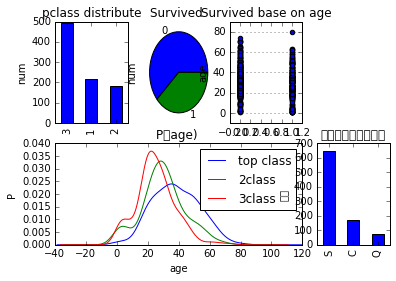

In [22]:
#-*- coding: utf-8 -*-
import matplotlib.pyplot as plt
fig = plt.figure()
fig.set(alpha=0.2)  # 设定图表颜色alpha参数

plt.subplot2grid((2,4),(0,1))             # 在一张大图里分列几个小图
data_train.Survived.value_counts().plot(kind='pie')# 柱状图 
plt.title(u"Survived ") # 标题
plt.ylabel(u"num")  

plt.subplot2grid((2,4),(0,0))
data_train.Pclass.value_counts().plot(kind="bar")
plt.ylabel(u"num")
plt.title(u"pclass distribute")

plt.subplot2grid((2,4),(0,2))
plt.scatter(data_train.Survived, data_train.Age)
plt.ylabel(u"age")                         # 设定纵坐标名称
plt.grid(b=True, which='major', axis='y') 
plt.title(u"Survived base on age")


plt.subplot2grid((2,4),(1,0), colspan=3)
data_train.Age[data_train.Pclass == 1].plot(kind='kde')   
data_train.Age[data_train.Pclass == 2].plot(kind='kde')
data_train.Age[data_train.Pclass == 3].plot(kind='kde')
plt.xlabel(u"age")# plots an axis lable
plt.ylabel(u"P") 
plt.title(u"P（age) ")
plt.legend((u'top class', u'2class',u'3class'),loc='best') # sets our legend for our graph.


plt.subplot2grid((2,4),(1,3))
data_train.Embarked.value_counts().plot(kind='bar')
plt.title(u"各登船口岸上船人数")
plt.ylabel(u"人数")  
plt.show()

bingo，图还是比数字好看多了。所以我们在图上可以看出来，被救的人300多点，不到半数；3等舱乘客灰常多；遇难和获救的人年龄似乎跨度都很广；3个不同的舱年龄总体趋势似乎也一致，2/3等舱乘客20岁多点的人最多，1等舱40岁左右的最多(→_→似乎符合财富和年龄的分配哈，咳咳，别理我，我瞎扯的)；登船港口人数按照S、C、Q递减，而且S远多于另外俩港口。

这个时候我们可能会有一些想法了：

> * 不同舱位/乘客等级可能和财富/地位有关系，最后获救概率可能会不一样
> * 年龄对获救概率也一定是有影响的，毕竟前面说了，副船长还说『小孩和女士先走』呢
> * 和登船港口是不是有关系呢？也许登船港口不同，人的出身地位不同？

口说无凭，空想无益。老老实实再来统计统计，看看这些属性值的统计分布吧。

###### 统计-属性与获救结果的关联统计

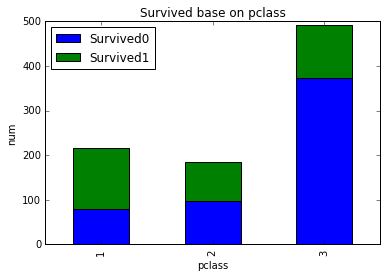

In [19]:
#看看各乘客等级的获救情况
fig = plt.figure()
fig.set(alpha=0.2)  # 设定图表颜色alpha参数

Survived_0 = data_train.Pclass[data_train.Survived == 0].value_counts()
Survived_1 = data_train.Pclass[data_train.Survived == 1].value_counts()
df=pd.DataFrame({u'Survived1':Survived_1, u'Survived0':Survived_0})
df.plot(kind='bar', stacked=True)
plt.title(u"Survived base on pclass")
plt.xlabel(u"pclass") 
plt.ylabel(u"num") 
plt.show()

啧啧，果然，钱和地位对舱位有影响，进而对获救的可能性也有影响啊←_←
咳咳，跑题了，我想说的是，明显等级为1的乘客，获救的概率高很多。恩，这个一定是影响最后获救结果的一个特征。

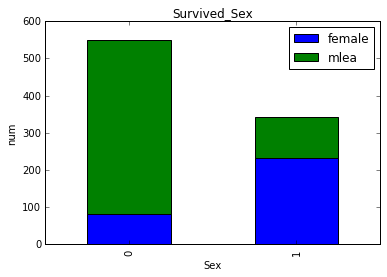

In [23]:
#看看各性别的获救情况
fig = plt.figure()
fig.set(alpha=0.2)  # 设定图表颜色alpha参数

Survived_m = data_train.Survived[data_train.Sex == 'male'].value_counts()
Survived_f = data_train.Survived[data_train.Sex == 'female'].value_counts()
df=pd.DataFrame({u'mlea':Survived_m, u'female':Survived_f})
df.plot(kind='bar', stacked=True)
plt.title(u"Survived_Sex")
plt.xlabel(u"Sex") 
plt.ylabel(u"num")
plt.show()

歪果盆友果然很尊重lady，lady first践行得不错。性别无疑也要作为重要特征加入最后的模型之中。

再来个详细版的好了。

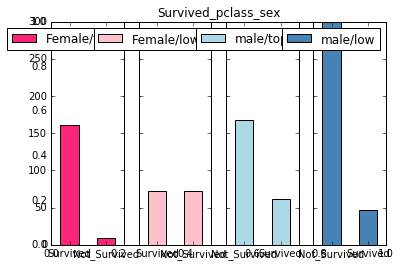

In [24]:
#然后我们再来看看各种舱级别情况下各性别的获救情况
fig=plt.figure()
fig.set(alpha=0.65) # 设置图像透明度，无所谓
plt.title(u"Survived_pclass_sex")

ax1=fig.add_subplot(141)
data_train.Survived[data_train.Sex == 'female'][data_train.Pclass != 3].value_counts().plot(kind='bar', label="female highclass", color='#FA2479')
ax1.set_xticklabels([u"Survived", u"Not_Survived"], rotation=0)
ax1.legend([u"Female/top"], loc='best')

ax2=fig.add_subplot(142, sharey=ax1)
data_train.Survived[data_train.Sex == 'female'][data_train.Pclass == 3].value_counts().plot(kind='bar', label='female, low class', color='pink')
ax2.set_xticklabels([u"Survived", u"Not_Survived"], rotation=0)
plt.legend([u"Female/low"], loc='best')

ax3=fig.add_subplot(143, sharey=ax1)
data_train.Survived[data_train.Sex == 'male'][data_train.Pclass != 3].value_counts().plot(kind='bar', label='male, high class',color='lightblue')
ax3.set_xticklabels([u"Not_Survived", u"Survived"], rotation=0)
plt.legend([u"male/top"], loc='best')

ax4=fig.add_subplot(144, sharey=ax1)
data_train.Survived[data_train.Sex == 'male'][data_train.Pclass == 3].value_counts().plot(kind='bar', label='male low class', color='steelblue')
ax4.set_xticklabels([u"Not_Survived", u"Survived"], rotation=0)
plt.legend([u"male/low"], loc='best')

plt.show()

恩，坚定了之前的判断。

我们看看各登船港口的获救情况。

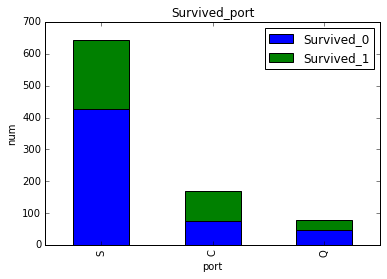

In [26]:
fig = plt.figure()
fig.set(alpha=0.2)  # 设定图表颜色alpha参数

Survived_0 = data_train.Embarked[data_train.Survived == 0].value_counts()
Survived_1 = data_train.Embarked[data_train.Survived == 1].value_counts()
df=pd.DataFrame({u'Survived_1':Survived_1, u'Survived_0':Survived_0})
df.plot(kind='bar', stacked=True)
plt.title(u"Survived_port")
plt.xlabel(u"port") 
plt.ylabel(u"num") 

plt.show()

下面我们来看看 堂兄弟/妹，孩子/父母有几人，对是否获救的影响。

In [31]:
g = data_train.groupby(['SibSp','Survived'])
df = pd.DataFrame(g.count()['PassengerId'])
print df
print df.describe()
g = data_train.groupby(['SibSp','Survived'])
df = pd.DataFrame(g.count()['PassengerId'])
print df
print df.describe()


                PassengerId
SibSp Survived             
0     0                 398
      1                 210
1     0                  97
      1                 112
2     0                  15
      1                  13
3     0                  12
      1                   4
4     0                  15
      1                   3
5     0                   5
8     0                   7
       PassengerId
count    12.000000
mean     74.250000
std     120.288385
min       3.000000
25%       6.500000
50%      14.000000
75%     100.750000
max     398.000000
                PassengerId
SibSp Survived             
0     0                 398
      1                 210
1     0                  97
      1                 112
2     0                  15
      1                  13
3     0                  12
      1                   4
4     0                  15
      1                   3
5     0                   5
8     0                   7
       PassengerId
count    12.000000
mean   

In [32]:
#ticket是船票编号，应该是unique的，和最后的结果没有太大的关系，先不纳入考虑的特征范畴把
#cabin只有204个乘客有值，我们先看看它的一个分布
data_train.Cabin.value_counts()

C23 C25 C27        4
G6                 4
B96 B98            4
D                  3
C22 C26            3
E101               3
F2                 3
F33                3
B57 B59 B63 B66    2
C68                2
B58 B60            2
E121               2
D20                2
E8                 2
E44                2
B77                2
C65                2
D26                2
E24                2
E25                2
B20                2
C93                2
D33                2
E67                2
D35                2
D36                2
C52                2
F4                 2
C125               2
C124               2
                  ..
F G63              1
A6                 1
D45                1
D6                 1
D56                1
C101               1
C54                1
D28                1
D37                1
B102               1
D30                1
E17                1
E58                1
F E69              1
D10 D12            1
E50                1
A14          

这三三两两的…如此不集中…我们猜一下，也许，前面的ABCDE是指的甲板位置、然后编号是房间号？…好吧，我瞎说的，别当真…

关键是Cabin这鬼属性，应该算作类目型的，本来缺失值就多，还如此不集中，注定是个棘手货…第一感觉，这玩意儿如果直接按照类目特征处理的话，太散了，估计每个因子化后的特征都拿不到什么权重。加上有那么多缺失值，要不我们先把Cabin缺失与否作为条件(虽然这部分信息缺失可能并非未登记，maybe只是丢失了而已，所以这样做未必妥当)，先在有无Cabin信息这个粗粒度上看看Survived的情况好了

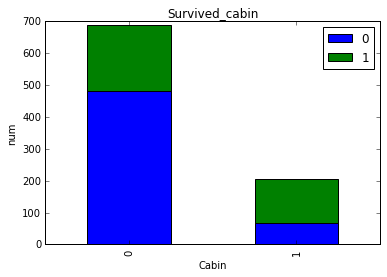

In [34]:
fig = plt.figure()
fig.set(alpha=0.2)  # 设定图表颜色alpha参数

Survived_cabin = data_train.Survived[pd.notnull(data_train.Cabin)].value_counts()
Survived_nocabin = data_train.Survived[pd.isnull(data_train.Cabin)].value_counts()
df=pd.DataFrame({u'1':Survived_cabin, u'0':Survived_nocabin}).transpose()
df.plot(kind='bar', stacked=True)
plt.title(u"Survived_cabin")
plt.xlabel(u"Cabin") 
plt.ylabel(u"num")
plt.show()

咳咳，有Cabin记录的似乎获救概率稍高一些，先这么着放一放吧。

# 2.简单数据预处理

大体数据的情况看了一遍，对感兴趣的属性也有个大概的了解了。
下一步干啥？咱们该处理处理这些数据，为机器学习建模做点准备了。

对了，我这里说的数据预处理，其实就包括了很多Kaggler津津乐道的***feature engineering***过程，灰常灰常有必要！

***『特征工程(feature engineering)太重要了！』***

***『特征工程(feature engineering)太重要了！』***

***『特征工程(feature engineering)太重要了！』***

恩，重要的事情说三遍。

先从最突出的数据属性开始吧，对，Cabin和Age，有丢失数据实在是对下一步工作影响太大。

先说Cabin，暂时我们就按照刚才说的，按Cabin有无数据，将这个属性处理成Yes和No两种类型吧。

再说Age：

######  2.1缺值补全
通常遇到缺值的情况，我们会有几种常见的处理方式
> * 如果缺值的样本**占总数比例极高**，我们可能就直接舍弃了，作为特征加入的话，可能反倒带入noise，影响最后的结果了
> * 如果缺值的样本**适中**，而该属性**非连续值**特征属性(比如说类目属性)，那就把**NaN作为一个新类别**，加到类别特征中
> * 如果缺值的样本**适中**，而该属性为**连续值**特征属性，有时候我们会考虑给定一个step(比如这里的age，我们可以考虑每隔2/3岁为一个步长)，然后把它**离散化**，之后把**NaN作为一个type**加到属性类目中。
> * 有些情况下，缺失的值个数并**不是特别多**，那我们也可以试着根据已有的值，**拟合**一下数据，补充上。


本例中，后两种处理方式应该都是可行的，我们先试试***拟合补全***吧(虽然说没有特别多的背景可供我们拟合，这不一定是一个多么好的选择)

我们这里用scikit-learn中的RandomForest来拟合一下缺失的年龄数据(注：RandomForest是一个用在原始数据中做不同采样，建立多颗DecisionTree，再进行average等等来降低过拟合现象，提高结果的机器学习算法，我们之后会介绍到)

In [61]:
from sklearn.ensemble import RandomForestRegressor

### 使用 RandomForestClassifier 填补缺失的年龄属性
def set_missing_ages(df):
    

    # 把已有的数值型特征取出来丢进Random Forest Regressor中
    age_df = df[['Age','Fare', 'Parch', 'SibSp', 'Pclass']]
    

    # 乘客分成已知年龄和未知年龄两部分
    known_age = age_df[age_df.Age.notnull()].as_matrix()
    unknown_age = age_df[age_df.Age.isnull()].as_matrix()
    
    
    

    # y即目标年龄
    y = known_age[:, 0]

    # X即特征属性值
    X = known_age[:, 1:]

    # fit到RandomForestRegressor之中
    rfr = RandomForestRegressor(random_state=0, n_estimators=2000, n_jobs=-1)
    rfr.fit(X, y)

    # 用得到的模型进行未知年龄结果预测
    
    predictedAges = rfr.predict(unknown_age[:, 1::])

    # 用得到的预测结果填补原缺失数据
    df.loc[ (df.Age.isnull()), 'Age' ] = predictedAges 

    return df, rfr

def set_Cabin_type(df):
    df.loc[ (df.Cabin.notnull()), 'Cabin' ] = "Yes"
    df.loc[ (df.Cabin.isnull()), 'Cabin' ] = "No"
    return df

data_train = pd.read_csv("dataset/Train.csv")
print data_train.info()
data_train, rfr = set_missing_ages(data_train)
data_train = set_Cabin_type(data_train)
print data_train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 73.1+ KB
 None
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex  Age  SibSp  \
0                            Braund, Mr. Owen Harris    male   22      1   
1  Cumings, Mrs. John Bradley (Florence 

In [62]:
print data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          891 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 73.1+ KB
None


恩。目的达到，OK了。

###### 2.2特征因子化
因为逻辑回归建模时，需要输入的特征都是数值型特征，我们通常会先对类目型的因子化
举个例子：

以Cabin为例，原本一个属性维度，因为其取值可以是[‘yes’,’no’]，而将其平展开为’Cabin_yes’,’Cabin_no’两个属性

> * 原本Cabin取值为yes的，在此处的”Cabin_yes”下取值为1，在”Cabin_no”下取值为0
> * 原本Cabin取值为no的，在此处的”Cabin_yes”下取值为0，在”Cabin_no”下取值为1

我们使用pandas的”get_dummies”来完成这个工作，并拼接在原来的”data_train”之上，如下所示。

In [64]:
dummies_Cabin = pd.get_dummies(data_train['Cabin'], prefix= 'Cabin')

dummies_Embarked = pd.get_dummies(data_train['Embarked'], prefix= 'Embarked')

dummies_Sex = pd.get_dummies(data_train['Sex'], prefix= 'Sex')

dummies_Pclass = pd.get_dummies(data_train['Pclass'], prefix= 'Pclass')

df = pd.concat([data_train, dummies_Cabin, dummies_Embarked, dummies_Sex, dummies_Pclass], axis=1)
df.drop(['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], axis=1, inplace=True)
df.head()

,PassengerId,Survived,Age,SibSp,Parch,Fare,Cabin_No,Cabin_Yes,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3
0,1,0,22,1,0,7.2500,1,0,0,0,1,0,1,0,0,1
1,2,1,38,1,0,71.2833,0,1,1,0,0,1,0,1,0,0
2,3,1,26,0,0,7.9250,1,0,0,0,1,1,0,0,0,1
3,4,1,35,1,0,53.1000,0,1,0,0,1,1,0,1,0,0
4,5,0,35,0,0,8.0500,1,0,0,0,1,0,1,0,0,1


bingo，我们很成功地把这些类目属性全都转成0，1的数值属性了。
这样，看起来，是不是我们需要的属性值都有了，且它们都是数值型属性呢。

###### 2.3    [scaling] 将一些变化幅度较大的特征化到[-1,1]之内。

In [70]:
import sklearn.preprocessing as preprocessing
scaler = preprocessing.StandardScaler()
df_age=df['Age'].reshape(-1, 1)
df_Fare=df['Fare'].reshape(-1, 1)
age_scale_param = scaler.fit(df_age)
df['Age_scaled'] = scaler.fit_transform(df_age, age_scale_param)
fare_scale_param = scaler.fit(df_Fare)
df['Fare_scaled'] = scaler.fit_transform(df_Fare, fare_scale_param)
df.head()

,PassengerId,Survived,Age,SibSp,Parch,Fare,Cabin_No,Cabin_Yes,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Age_scaled,Fare_scaled
0,1,0,22,1,0,7.2500,1,0,0,0,1,0,1,0,0,1,-0.561363,-0.502445
1,2,1,38,1,0,71.2833,0,1,1,0,0,1,0,1,0,0,0.613182,0.786845
2,3,1,26,0,0,7.9250,1,0,0,0,1,1,0,0,0,1,-0.267727,-0.488854
3,4,1,35,1,0,53.1000,0,1,0,0,1,1,0,1,0,0,0.392955,0.420730
4,5,0,35,0,0,8.0500,1,0,0,0,1,0,1,0,0,1,0.392955,-0.486337


恩，好看多了，万事俱备，只欠建模。马上就要看到成效了，哈哈。我们把需要的属性值抽出来，转成scikit-learn里面LogisticRegression可以处理的格式

# 3.逻辑回归建模

我们把需要的feature字段取出来，转成numpy格式，使用scikit-learn中的LogisticRegression建模。

In [71]:
from sklearn import linear_model

# 用正则取出我们要的属性值
train_df = df.filter(regex='Survived|Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')
train_np = train_df.as_matrix()

# y即Survival结果
y = train_np[:, 0]

# X即特征属性值
X = train_np[:, 1:]

# fit到RandomForestRegressor之中
clf = linear_model.LogisticRegression(C=1.0, penalty='l1', tol=1e-6)
clf.fit(X, y)

clf

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=1e-06,
          verbose=0, warm_start=False)

good，很顺利，我们得到了一个model
先淡定！淡定！你以为把test.csv直接丢进model里就能拿到结果啊…骚年，图样图森破啊！

我们的”test_data”也要做和”train_data”一样的预处理啊！！

In [75]:
data_test = pd.read_csv("dataset/test.csv")
data_test.loc[ (data_test.Fare.isnull()), 'Fare' ] = 0
# 接着我们对test_data做和train_data中一致的特征变换
# 首先用同样的RandomForestRegressor模型填上丢失的年龄
tmp_df = data_test[['Age','Fare', 'Parch', 'SibSp', 'Pclass']]
null_age = tmp_df[data_test.Age.isnull()].as_matrix()
# 根据特征属性X预测年龄并补上
X = null_age[:, 1:]
predictedAges = rfr.predict(X)
data_test.loc[ (data_test.Age.isnull()), 'Age' ] = predictedAges

data_test = set_Cabin_type(data_test)
dummies_Cabin = pd.get_dummies(data_test['Cabin'], prefix= 'Cabin')
dummies_Embarked = pd.get_dummies(data_test['Embarked'], prefix= 'Embarked')
dummies_Sex = pd.get_dummies(data_test['Sex'], prefix= 'Sex')
dummies_Pclass = pd.get_dummies(data_test['Pclass'], prefix= 'Pclass')


df_test = pd.concat([data_test, dummies_Cabin, dummies_Embarked, dummies_Sex, dummies_Pclass], axis=1)
df_test.drop(['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], axis=1, inplace=True)
df_test['Age_scaled'] = scaler.fit_transform(df_test['Age'].reshape(-1, 1), age_scale_param)
df_test['Fare_scaled'] = scaler.fit_transform(df_test['Fare'].reshape(-1, 1), fare_scale_param)
df_test.head()

,PassengerId,Age,SibSp,Parch,Fare,Cabin_No,Cabin_Yes,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Age_scaled,Fare_scaled
0,892,34.5,0,0,7.8292,1,0,0,1,0,0,1,0,0,1,0.307535,-0.496637
1,893,47.0,1,0,7.0000,1,0,0,0,1,1,0,0,0,1,1.256230,-0.511497
2,894,62.0,0,0,9.6875,1,0,0,1,0,0,1,0,1,0,2.394665,-0.463335
3,895,27.0,0,0,8.6625,1,0,0,0,1,0,1,0,0,1,-0.261683,-0.481704
4,896,22.0,1,1,12.2875,1,0,0,0,1,1,0,0,0,1,-0.641161,-0.416740


不错不错，数据很OK，差最后一步了。
下面就做预测取结果吧！！

In [85]:
test = df_test.filter(regex='Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')
predictions = clf.predict(test)
result = pd.DataFrame({'PassengerId':data_test['PassengerId'].as_matrix(), 'Survived':predictions.astype(np.int32)})
result.to_csv("logistic_regression_predictions.csv", index=False)

# 4.逻辑回归系统优化

###### 4.1 模型系数关联分析

亲，你以为结果提交上了，就完事了？
我不会告诉你，这只是万里长征第一步啊(泪牛满面)！！！这才刚撸完baseline model啊！！！还得优化啊！！！

>我们应该分析分析模型现在的状态了，是过/欠拟合？

>以确定我们需要更多的特征还是更多数据，或者其他操作。

我们有一条很著名的learning curves对吧。

不过在现在的场景下，先不着急做这个事情，我们这个baseline系统还有些粗糙，先再挖掘挖掘。

> * 首先，Name和Ticket两个属性被我们完整舍弃了(好吧，其实是因为这俩属性，几乎每一条记录都是一个完全不同的值，我们并没有找到很直接的处理方式)。

> * 然后，我们想想，年龄的拟合本身也未必是一件非常靠谱的事情，我们依据其余属性，其实并不能很好地拟合预测出未知的年龄。
> * 再一个，以我们的日常经验，小盆友和老人可能得到的照顾会多一些，这样看的话，年龄作为一个连续值，给一个固定的系数，应该和年龄是一个正相关或者负相关，似乎体现不出两头受照顾的实际情况，所以，说不定我们把年龄离散化，按区段分作类别属性会更合适一些。

把得到的model系数和feature关联起来看看


In [77]:
pd.DataFrame({"columns":list(train_df.columns)[1:], "coef":list(clf.coef_.T)})

,coef,columns
0,[-0.344228737918],SibSp
1,[-0.10493134809],Parch
2,[-0.0167752978148],Cabin_No
3,[0.885364482071],Cabin_Yes
4,[0.0],Embarked_C
5,[0.0],Embarked_Q
6,[-0.417263207647],Embarked_S
7,[1.97335441521],Sex_female
8,[-0.660641790185],Sex_male
9,[0.341142815955],Pclass_1


首先，大家回去前两篇文章里瞄一眼公式就知道，这些系数为正的特征，和最后结果是一个正相关，反之为负相关。

我们先看看那些权重绝对值非常大的feature，在我们的模型上：

> * Sex属性，如果是female会极大提高最后获救的概率，而male会很大程度拉低这个概率。
> * Pclass属性，1等舱乘客最后获救的概率会上升，而乘客等级为3会极大地拉低这个概率。
> *  有Cabin值会很大程度拉升最后获救概率(这里似乎能看到了一点端倪，事实上从最上面的有无Cabin记录的Survived分布图上看出，即使有Cabin记录的乘客也有一部分遇难了，估计这个属性上我们挖掘还不够)
> *   Age是一个负相关，意味着在我们的模型里，年龄越小，越有获救的优先权(还得回原数据看看这个是否合理）
> *   有一个登船港口S会很大程度拉低获救的概率，另外俩港口压根就没啥作用(这个实际上非常奇怪，因为我们从之前的统计图上并没有看到S港口的获救率非常低，所以也许可以考虑把登船港口这个feature去掉试试)。
> *  船票Fare有小幅度的正相关(并不意味着这个feature作用不大，有可能是我们细化的程度还不够，举个例子，说不定我们得对它离散化，再分至各个乘客等级上？)


###### 4.2 交叉验证

重点又来了：

> *  『要做交叉验证(cross validation)!』
> *  『要做交叉验证(cross validation)!』
> *  『要做交叉验证(cross validation)!』

恩，重要的事情说三遍。我们通常情况下，这么做cross validation：把train.csv分成两部分，一部分用于训练我们需要的模型，另外一部分数据上看我们预测算法的效果。

我们用scikit-learn的cross_validation来帮我们完成小数据集上的这个工作。

先简单看看cross validation情况下的打分

In [81]:
from sklearn import cross_validation

 #简单看看打分情况
clf2= linear_model.LogisticRegression(C=1.0, penalty='l1', tol=1e-6)
all_data = df.filter(regex='Survived|Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')
X = all_data.as_matrix()[:,1:]
y = all_data.as_matrix()[:,0]
print cross_validation.cross_val_score(clf, X, y, cv=5),cross_validation.cross_val_score(clf2, X, y, cv=5)

[ 0.81564246  0.81564246  0.78651685  0.78651685  0.81355932] [ 0.81564246  0.81564246  0.78651685  0.78651685  0.81355932]


等等，既然我们要做交叉验证，那我们干脆先把交叉验证里面的bad case拿出来看看，看看人眼审核，是否能发现什么蛛丝马迹，是我们忽略了哪些信息，使得这些乘客被判定错了。再把bad case上得到的想法和前头系数分析的合在一起，然后逐个试试。

下面我们做数据分割，并且在原始数据集上瞄一眼bad case：

In [84]:
# 分割数据，按照 训练数据:cv数据 = 7:3的比例
split_train, split_cv = cross_validation.train_test_split(df, test_size=0.3, random_state=0)
train_df = split_train.filter(regex='Survived|Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')
# 生成模型
clf = linear_model.LogisticRegression(C=1.0, penalty='l1', tol=1e-6)
clf.fit(train_df.as_matrix()[:,1:], train_df.as_matrix()[:,0])

# 对cross validation数据进行预测

cv_df = split_cv.filter(regex='Survived|Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')
predictions = clf.predict(cv_df.as_matrix()[:,1:])

origin_data_train = pd.read_csv("dataset/Train.csv")
bad_cases = origin_data_train.loc[origin_data_train['PassengerId'].isin(split_cv[predictions != cv_df.as_matrix()[:,0]]['PassengerId'].values)]
bad_cases.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
14,15,0,3,"Vestrom, Miss. Hulda Amanda Adolfina",female,14,0,0,350406,7.8542,NaN,S
49,50,0,3,"Arnold-Franchi, Mrs. Josef (Josefine Franchi)",female,18,1,0,349237,17.8000,NaN,S
55,56,1,1,"Woolner, Mr. Hugh",male,NaN,0,0,19947,35.5000,C52,S
65,66,1,3,"Moubarek, Master. Gerios",male,NaN,1,1,2661,15.2458,NaN,C
68,69,1,3,"Andersson, Miss. Erna Alexandra",female,17,4,2,3101281,7.9250,NaN,S


大家可以自己跑一遍试试，拿到bad cases之后，仔细看看。也会有一些猜测和想法。其中会有一部分可能会印证在系数分析部分的猜测，那这些优化的想法优先级可以放高一些。

现在有了”train_df” 和 “vc_df” 两个数据部分，前者用于训练model，后者用于评定和选择模型。可以开始可劲折腾了。

我们随便列一些可能可以做的优化操作：


> *  Age属性不使用现在的拟合方式，而是根据名称中的『Mr』『Mrs』『Miss』等的平均值进行填充。
> *  Age不做成一个连续值属性，而是使用一个步长进行离散化，变成离散的类目feature。
> *  Cabin再细化一些，对于有记录的Cabin属性，我们将其分为前面的字母部分(我猜是位置和船层之类的信息) 和 后面的数字部分(应该是房间号，有意思的事情是，如果你仔细看看原始数据，你会发现，这个值大的情况下，似乎获救的可能性高一些)。
> *  Pclass和Sex俩太重要了，我们试着用它们去组出一个组合属性来试试，这也是另外一种程度的细化。
> *  单加一个Child字段，Age<=12的，设为1，其余为0(你去看看数据，确实小盆友优先程度很高啊)
> *  如果名字里面有『Mrs』，而Parch>1的，我们猜测她可能是一个母亲，应该获救的概率也会提高，因此可以多加一个Mother字段，此种情况下设为1，其余情况下设为0
> *  登船港口可以考虑先去掉试试(Q和C本来就没权重，S有点诡异)
> *  把堂兄弟/兄妹 和 Parch 还有自己 个数加在一起组一个Family_size字段(考虑到大家族可能对最后的结果有影响)
> *  Name是一个我们一直没有触碰的属性，我们可以做一些简单的处理，比如说男性中带某些字眼的(‘Capt’, ‘Don’, ‘Major’, ‘Sir’)可以统一到一个Title，女性也一样。


大家接着往下挖掘，可能还可以想到更多可以细挖的部分。我这里先列这些了，然后我们可以使用手头上的”train_df”和”cv_df”开始试验这些feature engineering的tricks是否有效了。

试验的过程比较漫长，也需要有耐心，而且我们经常会面临很尴尬的状况，就是我们灵光一闪，想到一个feature，然后坚信它一定有效，结果试验下来，效果还不如试验之前的结果。恩，需要坚持和耐心，以及不断的挖掘。

###### 4.3 learning curves

有一个很可能发生的问题是，我们不断地做feature engineering，产生的特征越来越多，用这些特征去训练模型，会对我们的训练集拟合得越来越好，同时也可能在逐步丧失泛化能力，从而在待预测的数据上，表现不佳，也就是发生过拟合问题。

从另一个角度上说，如果模型在待预测的数据上表现不佳，除掉上面说的过拟合问题，也有可能是欠拟合问题，也就是说在训练集上，其实拟合的也不是那么好。

额，这个欠拟合和过拟合怎么解释呢。这么说吧：

    过拟合就像是你班那个学数学比较刻板的同学，老师讲过的题目，一字不漏全记下来了，于是老师再出一样的题目，分分钟精确出结果。but数学考试，因为总是碰到新题目，所以成绩不咋地。
    欠拟合就像是，咳咳，和博主level差不多的差生。连老师讲的练习题也记不住，于是连老师出一样题目复习的周测都做不好，考试更是可想而知了。

而在机器学习的问题上，对于过拟合和欠拟合两种情形。我们优化的方式是不同的。

***对过拟合而言，通常以下策略对结果优化是有用的：***
>做一下feature selection，挑出较好的feature的subset来做training

>提供更多的数据，从而弥补原始数据的bias问题，学习到的model也会更准确

***而对于欠拟合而言，我们通常需要更多的feature，更复杂的模型来提高准确度。***

著名的learning curve可以帮我们判定我们的模型现在所处的状态。我们以样本数为横坐标，训练和交叉验证集上的错误率作为纵坐标，两种状态分别如下两张图所示：过拟合(overfitting/high variace)，欠拟合(underfitting/high bias)

<img title="" alt="过拟合" src="http://7xo0y8.com1.z0.glb.clouddn.com/2_titanic/high_variance.png?imageView/2/w/400/q/100">
<img title="" alt="欠拟合" src="http://7xo0y8.com1.z0.glb.clouddn.com/2_titanic/high_bias.png?imageView/2/w/400/q/100">

我们也可以把错误率替换成准确率(得分)，得到另一种形式的learning curve(sklearn 里面是这么做的)。

回到我们的问题，我们用scikit-learn里面的learning_curve来帮我们分辨我们模型的状态。举个例子，这里我们一起画一下我们最先得到的baseline model的learning curve。

d:\anaconda2\lib\site-packages\sklearn\learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


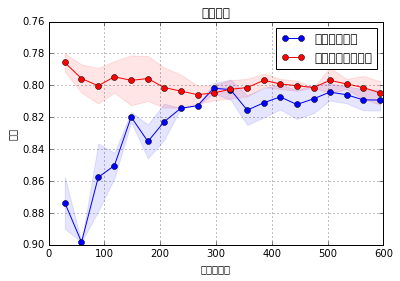

(0.80656968448540245, 0.018258876711338634)

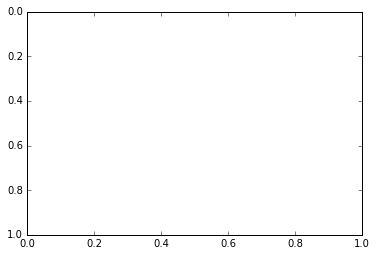

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.learning_curve import learning_curve

# 用sklearn的learning_curve得到training_score和cv_score，使用matplotlib画出learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, 
                        train_sizes=np.linspace(.05, 1., 20), verbose=0, plot=True):
    """
    画出data在某模型上的learning curve.
    参数解释
    ----------
    estimator : 你用的分类器。
    title : 表格的标题。
    X : 输入的feature，numpy类型
    y : 输入的target vector
    ylim : tuple格式的(ymin, ymax), 设定图像中纵坐标的最低点和最高点
    cv : 做cross-validation的时候，数据分成的份数，其中一份作为cv集，其余n-1份作为training(默认为3份)
    n_jobs : 并行的的任务数(默认1)
    """
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, verbose=verbose)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    if plot:
        plt.figure()
        plt.title(title)
        if ylim is not None:
            plt.ylim(*ylim)
        plt.xlabel(u"训练样本数")
        plt.ylabel(u"得分")
        plt.gca().invert_yaxis()
        plt.grid()

        plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, 
                         alpha=0.1, color="b")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, 
                         alpha=0.1, color="r")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label=u"训练集上得分")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="r", label=u"交叉验证集上得分")

        plt.legend(loc="best")

        plt.draw()
        plt.show()
        plt.gca().invert_yaxis()

    midpoint = ((train_scores_mean[-1] + train_scores_std[-1]) + (test_scores_mean[-1] - test_scores_std[-1])) / 2
    diff = (train_scores_mean[-1] + train_scores_std[-1]) - (test_scores_mean[-1] - test_scores_std[-1])
    return midpoint, diff

plot_learning_curve(clf, u"plot_learning_curve", X, y)

在实际数据上看，我们得到的learning curve没有理论推导的那么光滑哈，但是可以大致看出来，训练集和交叉验证集上的得分曲线走势还是符合预期的。

目前的曲线看来，我们的model并不处于overfitting的状态(overfitting的表现一般是训练集上得分高，而交叉验证集上要低很多，中间的gap比较大)。因此我们可以再做些feature engineering的工作，添加一些新产出的特征或者组合特征到模型中。

# 5.模型融合(model ensemble)

好了，终于到这一步了，我们要祭出机器学习/数据挖掘上通常最后会用到的大杀器了。恩，模型融合。

『强迫症患者』打算继续喊喊口号…
>* 『模型融合(model ensemble)很重要！』
>* 『模型融合(model ensemble)很重要！』
>* 『模型融合(model ensemble)很重要！』
重要的事情说三遍，恩，噢啦。

先解释解释，一会儿再回到我们的问题上哈。
啥叫模型融合呢，我们还是举几个例子直观理解一下好了。

大家都看过知识问答的综艺节目中，求助现场观众时候，让观众投票，最高的答案作为自己的答案的形式吧，每个人都有一个判定结果，最后我们相信答案在大多数人手里。

再通俗一点举个例子。你和你班某数学大神关系好，每次作业都『模仿』他的，于是绝大多数情况下，他做对了，你也对了。突然某一天大神脑子犯糊涂，手一抖，写错了一个数，于是…恩，你也只能跟着错了。
我们再来看看另外一个场景，你和你班5个数学大神关系都很好，每次都把他们作业拿过来，对比一下，再『自己做』，那你想想，如果哪天某大神犯糊涂了，写错了，but另外四个写对了啊，那你肯定相信另外4人的是正确答案吧？

最简单的模型融合大概就是这么个意思，比如分类问题，当我们手头上有一堆在同一份数据集上训练得到的分类器(比如logistic regression，SVM，KNN，random forest，神经网络)，那我们让他们都分别去做判定，然后对结果做投票统计，取票数最多的结果为最后结果。

bingo，问题就这么完美的解决了。

###### 模型融合可以比较好地缓解，训练过程中产生的过拟合问题，从而对于结果的准确度提升有一定的帮助。

话说回来，回到我们现在的问题。你看，我们现在只讲了logistic regression，如果我们还想用这个融合思想去提高我们的结果，我们该怎么做呢？

既然这个时候模型没得选，那咱们就在数据上动动手脚咯。大家想想，如果模型出现过拟合现在，一定是在我们的训练上出现拟合过度造成的对吧。

那我们干脆就不要用全部的训练集，
>*   ***每次取训练集的一个subset，做训练***
> *  *** 这样，我们虽然用的是同一个机器学习算法，但是得到的模型却是不一样的；***
>*   ***同时，因为我们没有任何一份子数据集是全的，因此即使出现过拟合，也是在子训练集上出现过拟合，而不是全体数据***
>*   ***这样做一个融合，可能对最后的结果有一定 的帮助。对，这就是常用的Bagging。***\

我们用scikit-learn里面的Bagging来完成上面的思路，过程非常简单。代码如下：

In [87]:
from sklearn.ensemble import BaggingRegressor

train_df = df.filter(regex='Survived|Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass.*|Mother|Child|Family|Title')
train_np = train_df.as_matrix()

# y即Survival结果
y = train_np[:, 0]

# X即特征属性值
X = train_np[:, 1:]

# fit到BaggingRegressor之中
clf = linear_model.LogisticRegression(C=1.0, penalty='l1', tol=1e-6)
bagging_clf = BaggingRegressor(clf, n_estimators=20, max_samples=0.8, max_features=1.0, bootstrap=True, bootstrap_features=False, n_jobs=-1)
bagging_clf.fit(X, y)

test = df_test.filter(regex='Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass.*|Mother|Child|Family|Title')
predictions = bagging_clf.predict(test)
result = pd.DataFrame({'PassengerId':data_test['PassengerId'].as_matrix(), 'Survived':predictions.astype(np.int32)})
result.to_csv("logistic_regression_bagging_predictions.csv", index=False)

# 6.总结

文章稍微有点长，非常感谢各位耐心看到这里。
总结的部分，我就简短写几段，出现的话，很多在文中有对应的场景，大家有兴趣再回头看看。

对于任何的机器学习问题，不要一上来就追求尽善尽美，先用自己会的算法撸一个baseline的model出来，再进行后续的分析步骤，一步步提高。

在问题的结果过程中：

>*   ***『对数据的认识太重要了！』***『
>*   ***『数据中的特殊点/离群点的分析和处理太重要了！』***『
>*   ***『特征工程(feature engineering)太重要了！』***『
>*   *** 『模型融合(model ensemble)太重要了！』***『


<img title="" alt="机器学习解决问题的过程" src="http://7xo0y8.com1.z0.glb.clouddn.com/2_titanic/process.png?imageView/2/w/700/q/100">